# Customer segmentation with E-commercial data 

## 1. Data preparation

In [ ]:
import pandas as pd
df_initial = pd.read_csv('/content/drive/My Drive/Google colab data/data.csv',
                   encoding= 'ISO-8859-1',dtype={'CustomerID': str,'InvoiceID': str})
display(df_initial[:5])
# StockCode is Item code

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
df_initial['InvoiceDate']= pd.to_datetime(df_initial['InvoiceDate'])

In [ ]:
df_initial.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


Lưu ý, ta cần tải phiên bản mới nhất trước khi sử dụng pandas profiling

In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import pandas_profiling
from pandas_profiling import ProfileReport
from ipywidgets import widgets
profile=ProfileReport(df_initial,title='Pandas Profiling Report', explorative=True)
profile

Ta thấy khoảng 25% customer id là missing value. Hay nói cách khác, ta không biết khách hàng nào thực hiện dao dịch do đó ta sẽ loại bỏ những missing value này vì chúng không thật sự có ý nghĩa cũng khó áp dụng kĩ thuật impute missing value. Ngoài ra ta cũng loại bỏ các giao dịch bị trùng, đó có thể là do lỗi hệ thống

In [ ]:
df_initial.dropna(subset=['CustomerID'], inplace=True)

df_initial.drop_duplicates(inplace=True)

## 2. Understanding data 

### 2.1 Customer and product

Dữ liệu này chứa thông tin khoảng 400.000 đơn hàng. Một giao dịch có thể bao gồm nhiều đơn hàng với các sản phẩm khác nhau. Vậy số lượng giao dịch,người tiêu dùng và sản phẩm là bao nhiêu

In [ ]:
pd.DataFrame({'transaction':len(df_initial['InvoiceNo'].value_counts()),
              'customer':len(df_initial['CustomerID'].value_counts()),
              'product':len(df_initial['StockCode'].value_counts())}, index=['quantity'])

,transaction,customer,product
quantity,22190,4372,3684


Như vậy có tổng cộng 4372 khách hàng thực hiện 22190 giao dịch với 3684 sản phẩm khác nhau. Trung bình, một khách hàng thực hiện khoảng 5,5 giao dịch trong 10 tháng.

Tiếp đến ta sẽ xác định số lượng sản phẩm được mua trong mỗi giao dịch



In [ ]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


InvoiceNo có kí hiệu đầu tiên là C có nghĩa là đơn hàng đó đã bị hủy. Do đó ta sẽ đếm số đơn hàng bị hủy

In [ ]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]

print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


Như vậy khoảng 20% giao dịch là bị hủy( khá lớn). Tiếp đến ta sẽ nhìn vào dữ liệu.

In [ ]:
display(df_initial.sort_values('CustomerID')[:5])

Để ý rằng, khi một đơn hàng bị hủy sẽ có một dòng khác xuất hiện giống hệt với đơn hàng đã đặt trước đo ngoại trừ biến quantity và invoicedate. Ta quyết định check xem suy nghĩ đó có đúng hay không

In [ ]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Như vậy giả thiết không đúng. Mức gía âm cũng có thể là do đơn hàng đó được giảm giá. Do đó đơn bị hủy không nhất thiết phải tương ứng với đơn trước đó. Cung có thể là do đơn hàng bị hủy một phần chứ không phải toàn bộ




In [ ]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


### 2.2. StockCode

Ta có thể thấy một vài giá trị của cột StockCode đại diện cho một loại giao dịch cụ thể( vd D--> Discount). Ta cùng xem xét các giá trị đó

In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


### 2.3. Basket Price


Ta tạo cột mới chứa tổng giá trị của mỗi đơn hàng

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Tiếp đến ta sẽ tổng hợp giá trị của mỗi giao dịch

In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()

basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


## 3. Phân loại sản phẩm

phần này m sẽ sử dụng 2 trường liên quan đến sản phẩm: description và stockcode để phân loại sản phẩm

### 3.1. Product description

Ở phần này ta se làm việc với text data( trường description) để trích xuất những thông tin hữu ích cho việc phân loại sản phẩm

In [ ]:
is_noun = lambda pos: pos[:2]=='NN'

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


def keyword_inventory( dataframe, columns='Description'):
  stemmer= nltk.stem.SnowballStemmer('english') # Tra lai goc tu

  keywords_root= dict()
  keywords_select = dict()

  category_keys = []
  count_keywords = dict()

  icount=0

  for s in dataframe[columns]:
    if pd.isnull(s): continue
    lines = s.lower()
    tokenized = nltk.word_tokenize(lines)
    # Lấy tất cả danh từ( keyword) trong mỗi description
    nouns = [word for (word,pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
    # Nhóm tất cả các keyword thu được trên mỗi discription có cùng gốc từ lại và lưu vào keywords_root (root:{keywords})
    for t in nouns:
      t = t.lower()
      root = stemmer.stem(t)
      if root in keywords_root:
        keywords_root[root].add(t)
        count_keywords[root] += 1
      else:
        keywords_root[root] = {t}
        count_keywords[root] = 1
  # Trong các keywords, lấy keywords có chiều dài ngắn nhất và lưu vào category_keys va keywords_select
  for s in keywords_root.keys():
    if len(keywords_root[s]) > 1:
      min_length=1000
      for k in keywords_root[s]:
        if len(k) < min_length:
          clef = k; min_length = len(k)
            
      category_keys.append(clef)
      keywords_select[s] = clef
    else:
      category_keys.append(list(keywords_root[s])[0])
      keywords_select[s] = list(keywords_root[s])[0]
  print("Nb of keywords in variable '{}': {}".format(columns,len(category_keys)))
  return category_keys, keywords_root, keywords_select, count_keywords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df_product = pd.DataFrame(df_initial['Description'].unique()).rename(columns={0: 'Description'})

keywords, keywords_root, keywords_select, count_keywords = keyword_inventory(df_product)

Nb of keywords in variable 'Description': 1483


In [ ]:
count_keywords.items()

In [ ]:
list_products = []
for k,v in count_keywords.items():
  list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x: x[1], reverse = True)

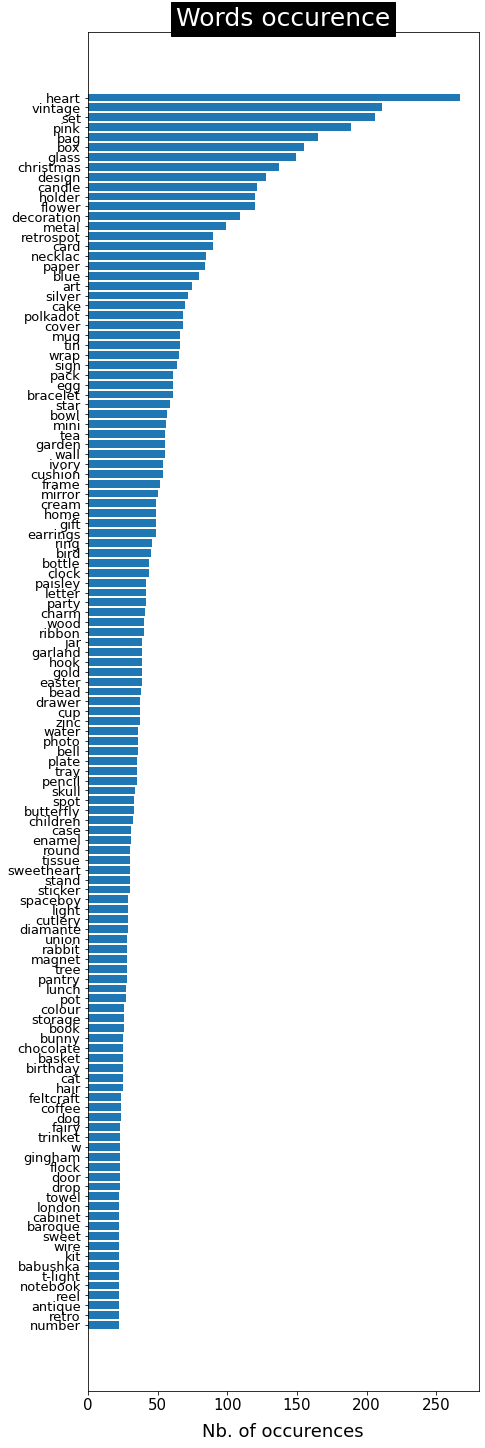

In [ ]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

import matplotlib.pyplot as plt
plt.rc('font',weight = 'normal')
fig, ax = plt.subplots( figsize = (7,25))

y_axis = [i[1] for i in liste[:125] ]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125] ]

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### 3.2. Defining product category

Xem cacs keywords, ta thấy một số là không có ý nghía. Do đó ta loại bỏ các keywords nằm trong( pink, blue, tag,...), chiều dài nhở hơn 3 và số lần xuất hiện ít hơn 15

In [ ]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

print('Nb of keyword: ',len(list_products))

Nb of keyword:  193


### 3.3. Data Encoding

Tao một ma trận X, mỗi cột đại diện cho một keyword được chọn và mỗi hàng đại diện cho một sản phẩm, nếu selected keywords thuộc product ( descreiption) nào thì giá trị của nó bằng 1

In [ ]:
liste_products = df_cleaned['Description'].unique()

X = pd.DataFrame()
for key, occurence in list_products:
  X[key] = list(map(lambda x:int(key.upper() in x), liste_products))
X.head(10)

,heart,holder,metal,cream,hanger,union,water,bottle,box,glass,star,hand,jack,warmer,bird,kitchen,feltcraft,ivory,colour,vintage,jigsaw,alphabet,home,jam,jar,rack,clock,bunny,tape,retrospot,tea,towel,round,woodland,spaceboy,lunch,london,bag,design,toadstool,...,craft,tree,wreath,gingham,lace,biscuit,gift,medium,bracelet,hair,diamante,ring,stripe,flock,regency,antique,easter,childs,dish,shape,pan,pantry,door,food,image,retro,book,number,hen,chick,drop,earrings,leaf,shell,bead,jewel,orbit,doiley,wallet,point
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ta lập một bảng vùng giá để xem một sản phẩm cụ thể sẽ namfwd trong vùng giá nào và mỗi vùng giá sẽ có bao nhiêu sản phẩm

In [ ]:
threshold = [0, 1, 2, 3, 5, 10]

# tạo tên cho 6 cột mới tương ứng với vùng giá
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

# Nếu sảm phầm có giá trong vùng label_col[j] thì 
# giá trị của cột tương ứng với sản phẩm đó sẽ có giá trị là 1
for i , prod in enumerate(liste_products):
  price = df_cleaned[df_cleaned['Description']== prod]['UnitPrice'].mean()
  j = 0
  while price > threshold[j]:
    j += 1
    if j == len(threshold): break
  X.loc[i, label_col[j-1]] = 1

In [ ]:
X.iloc[:5,-6:] 
# Nhìn kết quả có thể thấy sp thứ nhất nằm trong vùng giá (2,3)

,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [ ]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))
# Như vậy vùng giá (0,1) sẽ có 964 sản phẩm

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


### 3.4. Creating clusters of products

Tiếp theo ta sử dụng Kmeans để phân loại sản phẩm va X lúc này chính là training datasest

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.12267556967825143
For n_clusters = 5 The average silhouette_score is : 0.12124038123044968
For n_clusters = 6 The average silhouette_score is : 0.14509988406712557
For n_clusters = 7 The average silhouette_score is : 0.13967070684813226
For n_clusters = 8 The average silhouette_score is : 0.1495445500379362
For n_clusters = 9 The average silhouette_score is : 0.14009042118114465


Ta thấy điểm số cũng same same nhau. Nếu ta chạy một model nhiều lần thì cũng có thể dẫn đến kết quả này vì mỗi lần chạy thifd sẽ khởi tạo các centroid khác nhau. Như vậy sự chênh lệch này không quá đáng kể để làm căn cứ xác định số cluster. Môt quan sát nữa là, với số cluster lớn hơn 5 thì một số cluster sẽ có rất ít giá trị( product). Do đó ta sẽ chọn số cluster sau đó chạy mô hình tới khi được kết quả tốt nhất

In [ ]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 5 The average silhouette_score is : 0.14740815062347604


Check số thành phần trong mỗi cluster

In [ ]:
pd.Series(clusters).value_counts()

1    1159
3     964
2     673
4     606
0     476
dtype: int64

Tiếp đến ta sẽ xem chất lượng của mô hình phân loại sản phẩm cũng như nội dung của từng cụm

Có 3 cách đó là word cloud, Silhouette intra-cluster score và PCA. Trong phần này m sẽ sử dụng word cloud

## 4. Customer Category



### 4.1. Create features

Đầu tiên ta sẽ thêm cột category product vào file dữ liệu

In [ ]:
cor = dict()
for key, val in zip(liste_products,clusters):
  cor[key] = val

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(cor)
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,0


Tiếp đến ta sẽ thêm biến Categ_N ( N \in [1,4]) thể hiện tổng giá trị của mỗi đơn hàng

In [ ]:
for i in range(5):
  col = 'categ_{}'.format(i)
  df_temp = df_cleaned[df_cleaned['categ_product'] == i]
  total_price = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
  total_price = total_price.apply (lambda x: x if x>0 else 0)
  df_cleaned.loc[:, col] = total_price
  df_cleaned[col].fillna(0, inplace = True)

df_cleaned.iloc[:5,-7:]

,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,15.30,3,0.00,0.0,0.0,15.3,0.0
1,20.34,0,20.34,0.0,0.0,0.0,0.0
2,22.00,0,22.00,0.0,0.0,0.0,0.0
3,20.34,0,20.34,0.0,0.0,0.0,0.0
4,20.34,0,20.34,0.0,0.0,0.0,0.0


Từ trước tới giờ là ta phân tích thông tin của từng sản phẩm. Oử phần này ta sẽ tạo dataframe mới ( basket price) để phân tích thông tin của một giao dịch, đơn hàng( 1 giao dịch, đơn hàng có thể bao gồm nhiều sản phẩm)

In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

temp.head()

for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,293.35,124.44,187.2,83.40,23.40,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,169.20,38.25,130.5,53.10,84.34,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,115.00,38.25,330.9,71.10,81.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,168.76,19.90,74.4,78.06,41.40,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,158.16,136.05,109.7,119.70,61.30,2011-08-02 08:48:00.000000000


Vì basket price chứa thông tin dữ liệu của 12 tháng. Về sau, một trong những mục tiêu là phân loại và dự báo thói quen chi tiêu của khách hàng. Do đó ta sẽ tách tập dữ liệu này thành train data và test data

In [ ]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [ ]:
import datetime
set_train = basket_price[basket_price['InvoiceDate'] < datetime.datetime(2011,10,1)]
set_test  = basket_price[basket_price['InvoiceDate'] >= datetime.datetime(2011,10,1)]
basket_price = set_train.copy(deep = True)

Tiếp theo ta sẽ xác định số lần giao dịch cũng như min ,max, avg, sum giá trị hàng hóa trong các lần mua hàng cuar mỗi customer

In [ ]:
transactions_per_user = basket_price.groupby(by='CustomerID')['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /transactions_per_user['sum']*100

transactions_per_user.reset_index( inplace= True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]                                                                                                  

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,32.408290,12.787815,29.836681,14.524555,10.442659
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,41.953217,0.000000,38.016069
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,11.961722,48.444976,27.900718,11.692584
3,12352,6,144.35,840.30,345.663333,2073.98,15.711338,67.534402,12.892120,3.370331,0.491808
4,12353,1,89.00,89.00,89.000000,89.00,0.000000,67.078652,13.033708,19.887640,0.000000


Cuỗi cùng ta sẽ tính thời gian trôi qua từ lần đầu tiên mua hàng đến lần cuối cùng mua hàng thông qua việc tạo 2 biến mới là FirstPurchase và LastPurchase

In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

fp = first_registration.applymap(lambda x:(last_date - x.date()).days)
lp = last_registration.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:,'FirstPurchase'] = fp.reset_index()['InvoiceDate']
transactions_per_user.loc[:,'LasrPurchase'] = lp.reset_index()['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,FirstPurchase,LasrPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,32.408290,12.787815,29.836681,14.524555,10.442659,297,59
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,41.953217,0.000000,38.016069,288,5
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,11.961722,48.444976,27.900718,11.692584,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,15.711338,67.534402,12.892120,3.370331,0.491808,226,2
4,12353,1,89.00,89.00,89.000000,89.00,0.000000,67.078652,13.033708,19.887640,0.000000,134,134


Co một loại khách hàng chỉ thực hiện đúng một lần giao dịch. Một trong những mục tiêu là nghĩ cách dữ chân những khách hàng này Và tôi phát hiện ra loại này chiếm đên 1/3 số khách hàng

In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]

print('Tỷ lệ khách hàng thực hiện một giao dịch: {}/{}  ({})'.format(n1,n2,n1*100/n2))

Tỷ lệ khách hàng thực hiện một giao dịch: 1445/3608  (40.049889135254986)


### 4.2. Phân loại khách hàng

đầu tiên ta sẽ chọn các feature và chuẩn hóa dữ liệu

In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
X_customer = selected_customers[list_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_customer)
Scaled_X_customer = scaler.transform(X_customer)

Tiếp theo ta sử dụng PCA để giảm chiều dữ liệu

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Scaled_X_customer)
pca_samples = pca.transform(Scaled_X_customer)

Ta sử dụng KMeans và Gaussian Mixture với tập dữ liệu Scaled_X_customer để phân loại khách hàng. Sau khi chạy vơi nhiều cluster khác nhau thì ta tìm đc 11 là số cluster tốt nhất

In [ ]:
n_clusters = 11
kmeans = KMeans(n_clusters =11, n_init= 100)
kmeans.fit(Scaled_X_customer)
clusters_clients = kmeans.predict(Scaled_X_customer)
silhouette_avg = silhouette_score(Scaled_X_customer, clusters_clients)

selected_customers.loc[:, 'cluster'] = clusters_clients
print('score of silhouette: {:<.3f}'.format(silhouette_avg))

score of silhouette: 0.217


In [ ]:
from sklearn.mixture import BayesianGaussianMixture
bayes_gm = BayesianGaussianMixture(n_components = 20, n_init = 30)
bayes_gm.fit(Scaled_X_customer)
clusters_clients_2 = bayes_gm.predict( Scaled_X_customer)

In [ ]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. of clients']).T

,0,1,7,5,4,8,6,2,10,3,9
nb. of clients,1552,499,331,295,286,265,191,160,12,9,8


In [ ]:
pd.DataFrame(pd.Series(clusters_clients_2).value_counts(), columns = ['nb. of clients']).T

## 5. Classification of customer

Để cho đơn giản, ta xây dựng một class để phân loại

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, train_size = 0.8)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Tiếp đến ta sẽ sử dụng các thuật toán phân loại( classification) và chọn thuật toán tốt nhất



In [ ]:
from sklearn import svm
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
print(svc.grid_predict(X_test, Y_test))

Precision: 71.88 % 
None


In [ ]:
from sklearn import ensemble
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.17 % 


In [ ]:
from sklearn import neighbors
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 80.75 % 


In [ ]:
from sklearn.ensemble import VotingClassifier
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)

knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)

votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('knn', knn_best)
                                                ], voting='soft') 

votingC = votingC.fit(X_train, Y_train)

In [ ]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 90.03 % 


In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=f4b104db7f34c9b726641619b6c49a9e95c4fb27191ac631693951e1cb00dba5
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
import numpy as np
import sklearn
from xgboost import XGBClassifier
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

train_xgb = xgb.DMatrix(X_train.values, label= Y_train.values)
test_xgb = xgb.DMatrix(X_test.values, label = Y_test.values)
def bayes_xgboost(learning_rate,
                  n_estimators,
                  gamma,
                  subsample,
                  colsample,
                  max_depth):
  #max_depth = int(max_depth)
  #n_estimators = int(n_estimators)

  estimator = xgb.cv(max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        objective = 'multi:sortmax',
        
        metrics='auc',
        dtrain =train_xgb,
        nfold = 5,
        num_boost_round = 100,
        
        )
  return estimator['test_auc_mean'].iloc[-1]

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (0.1, 1.0),  # Change for big datasets
    'colsample': (0.1, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

optimizer = BayesianOptimization(
    f=bayes_xgboost,
    pbounds=pbounds,
    verbose=2,
    random_state=1,

)

optimizer.maximize(init_points=2,n_iter=3)
print(optimizer.max)

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

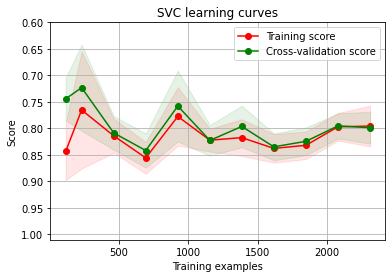

In [ ]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])